In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Scroll to the very bottom!

In [15]:
with open("./NiZr1.steps") as f:
    header = f.readline().strip().split()
print(header)
md_data = np.loadtxt("./NiZr1.steps", skiprows=1).T
print(md_data.shape)

['Step', 'Temp', 'Press', 'TotEng', 'PotEng', 'Enthalpy']
(6, 4029)


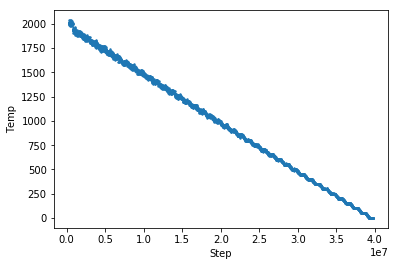

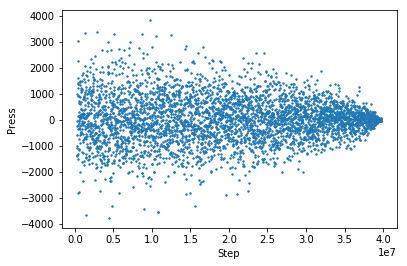

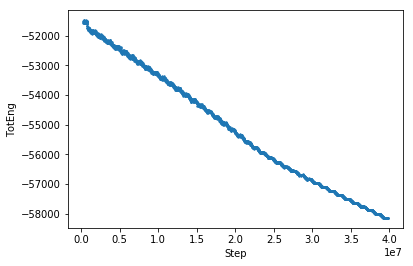

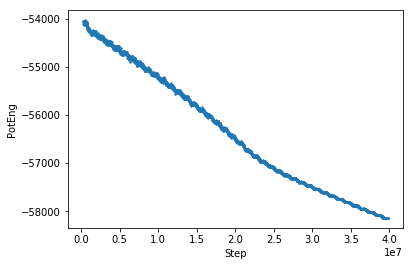

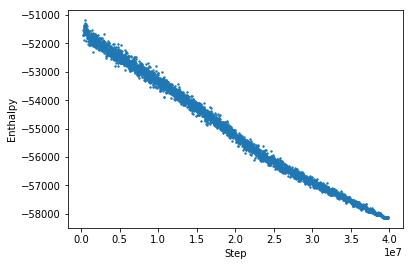

In [19]:
for i in range(1, len(header)):
    plt.scatter(md_data[0, :], md_data[i, :], s=2)
    plt.xlabel(header[0])
    plt.ylabel(header[i])
    plt.show()

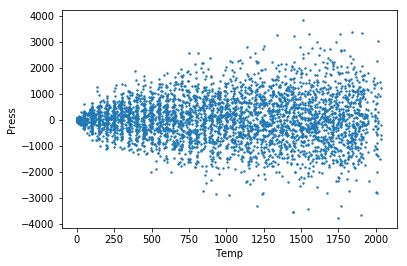

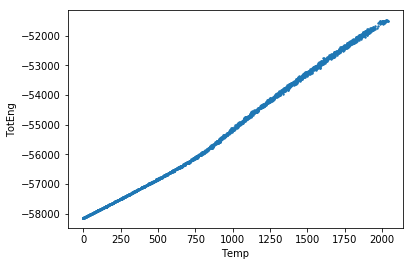

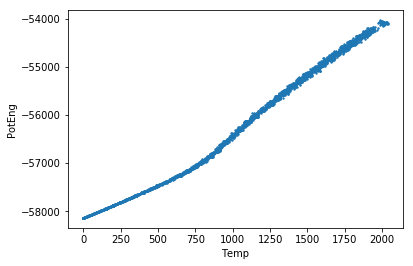

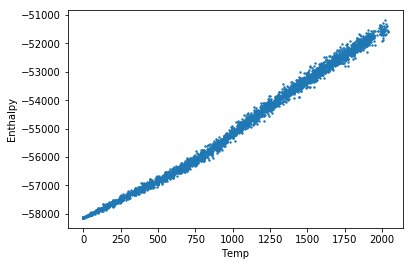

In [20]:
for i in range(2, len(header)):
    plt.scatter(md_data[1, :], md_data[i, :], s=2)
    plt.xlabel(header[1])
    plt.ylabel(header[i])
    plt.show()

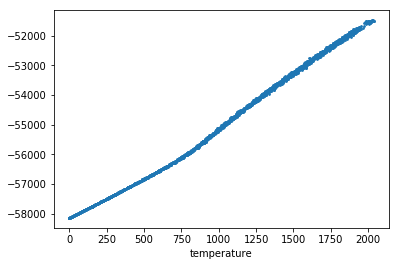

In [24]:
temp = md_data[1, :]
tenergy = md_data[3, :]
plt.scatter(temp, tenergy, s=3)
plt.xlabel('temperature')
plt.show()

In [31]:
def two_lines(x, a, b, c, d):
    one = a*x + b
    two = c*x + d
    return np.maximum(one, two)

664.2893999438629


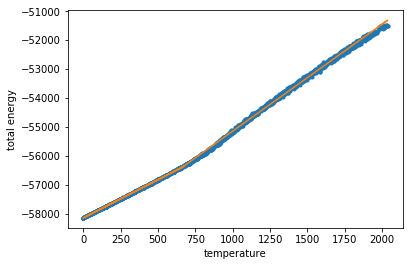

In [62]:
# This significantly underestimats Tg because of the bend in the high-T data.

# But I'm pretty confident in the fit to the bottom half of the data. Let's use that fit to calculate Tg, see below.

X, Y = temp, tenergy
pw0 = (.02, 30, .2, -2000) # a guess for slope, intercept, slope, intercept
pw, cov = curve_fit(two_lines, X, Y, pw0)
crossover = (pw[3] - pw[1]) / (pw[0] - pw[2])
print(crossover)

plt.plot(X, Y, '.', X, two_lines(X, *pw), '-')
plt.xlabel("temperature")
plt.ylabel("total energy")
plt.show()

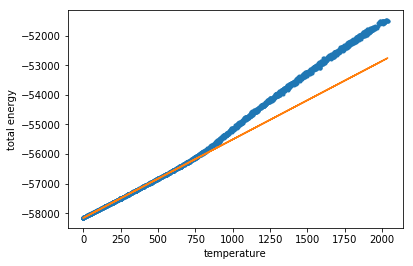

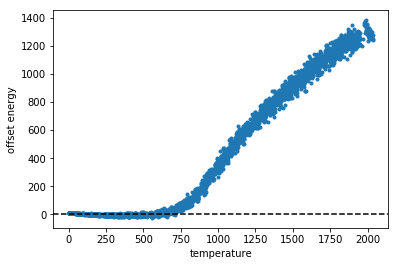

In [64]:
# Look at when the bottom data starts to deviate

def one_line(x, a, b):
    one = a*x + b
    return one

Y0 = one_line(X, pw[0], pw[1])
plt.plot(X, Y, '.')
plt.plot(X, Y0)
plt.xlabel("temperature")
plt.ylabel("total energy")
plt.show()

dY = Y - Y0
plt.plot(X, dY, '.')
plt.axhline(y=0.0, color='k', linestyle='--')
plt.xlabel("temperature")
plt.ylabel("offset energy")
plt.show()

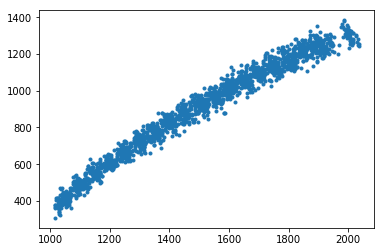

In [75]:
T_cutoff = temp[np.where(dY > dY.max() * 0.3)].min()

temp_over_cutoff = np.where(temp > T_cutoff)
plt.plot(temp[temp_over_cutoff], dY[temp_over_cutoff], '.')
plt.show()

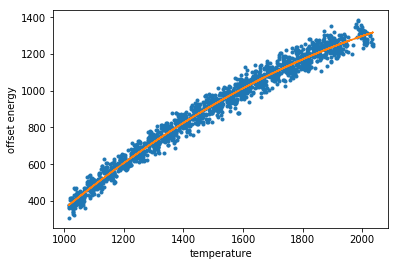

In [76]:
def curve(X, a, b, c):
    return a*X**2 + b*X + c

X, Y = temp[temp_over_cutoff], dY[temp_over_cutoff]
pw0 = (1, 1, 1)
pw, cov = curve_fit(curve, X, Y, pw0)

plt.plot(X, Y, '.')
plt.plot(X, curve(X, *pw), '-')
plt.xlabel("temperature")
plt.ylabel("offset energy")
plt.show()

746.85675


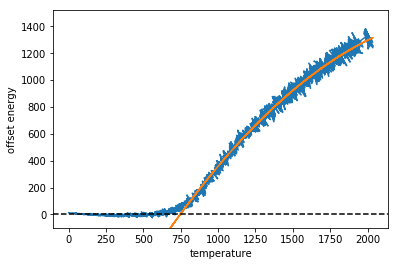

In [77]:
X, Y = temp, tenergy

Y0_curve = curve(X, *pw)

# Calculate Tg
Tg = X[np.argmin(np.abs(Y0_curve))]
print(Tg)

plt.plot(X, dY)
plt.plot(X, Y0_curve)
plt.axhline(y=0.0, color='k', linestyle='--')
plt.xlabel("temperature")
plt.ylabel("offset energy")
plt.ylim([-100, None])
plt.show()

In [50]:
# Nice! Let's make that into a function

from scipy.optimize import curve_fit

def _calculate_Tg(temperature, total_energy, a, plot=False):
    
    def two_lines(x, a, b, c, d):
        one = a*x + b
        two = c*x + d
        return np.maximum(one, two)
    
    X, Y = temperature, total_energy
    pw0 = (1, 1, 1, 1)
    pw, cov = curve_fit(two_lines, X, Y, pw0)
    
    # Look at when the bottom data starts to deviate
    
    def one_line(x, a, b):
        one = a*x + b
        return one

    Y0 = one_line(X, pw[0], pw[1])
    dY = Y - Y0
    
    if plot:
        plt.plot(X, Y, '.')
        plt.plot(X, Y0)
        plt.xlabel("temperature")
        plt.ylabel("total energy")
        plt.show()
    
    T_cutoff = temperature[np.where(dY > dY.max() * a)].min()
    temp_over_cutoff = np.where(temperature > T_cutoff)
    
    # Approximate the top half of the data using a quadratic
    def curve(X, a, b, c):
        return a*X**2 + b*X + c

    X, Y = temperature[temp_over_cutoff], dY[temp_over_cutoff]
    pw0 = (1, 1, 1)
    pw, cov = curve_fit(curve, X, Y, pw0)

    X, Y = temperature, total_energy

    Y0_curve = curve(X, *pw)

    # Calculate Tg based on when Y0_curve hits Y=0
    Tg = X[np.argmin(np.abs(Y0_curve))]

    if plot:
        plt.plot(X, dY)
        plt.plot(X, Y0_curve)
        plt.axhline(y=0.0, color='k', linestyle='--')
        plt.xlabel("temperature")
        plt.ylabel("offset energy")
        plt.ylim([-100, None])
        plt.show()
    
    return Tg

def calculate_Tg(temperature, total_energy, plot=False):
    # This uses the above function but optimized the paramter a
    # The opt may be wrong but it works well for the two cases I tried
    maxx = (0, 0)
    for a in np.arange(0.01, 0.5, 0.01):
        Tg = _calculate_Tg(temperature, total_energy, a=a, plot=False)
        if Tg > maxx[1]:
            maxx = (a, Tg)
    a = maxx[0]
    Tg = _calculate_Tg(temperature, total_energy, a=a, plot=plot)
    return Tg

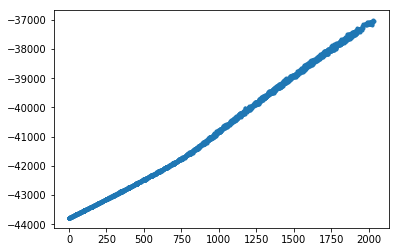

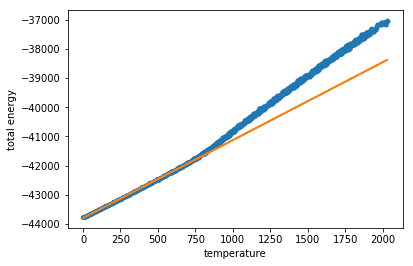

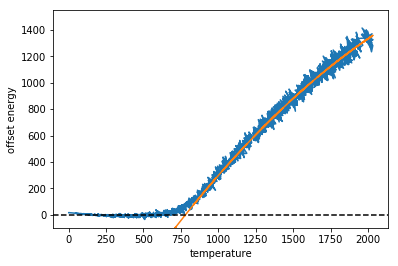

Tg ~= 782.23744


In [62]:
#filename = "./Al92Sm8_1.steps"
#filename = "./NiZr1.steps"
filename = "./PdSi1.lammps.steps"

with open(filename) as f:
    header = f.readline().strip().split()
md_data = np.loadtxt(filename, skiprows=1).T
#print(header)
#print(md_data.shape)

temperature = header.index('Temp')
total_energy = header.index('TotEng')
temperature = md_data[temperature, :]
total_energy = md_data[total_energy, :]
plt.plot(temperature, total_energy, '.-')
plt.show()

Tg = calculate_Tg(temperature, total_energy, plot=True)
print(f"Tg ~= {Tg}")